In [2]:

import util.datasets

In [3]:
img, anno = util.datasets.pascal_voc_detection('/home/FYP/wang1570/datasets/pascal-voc-2012/VOCdevkit/VOC2012').load()

In [10]:
anno[0]

OrderedDict([('folder', 'VOC2012'),
             ('filename', '2008_000002.jpg'),
             ('source',
              OrderedDict([('database', 'The VOC2008 Database'),
                           ('annotation', 'PASCAL VOC2008'),
                           ('image', 'flickr')])),
             ('size',
              OrderedDict([('width', '500'),
                           ('height', '375'),
                           ('depth', '3')])),
             ('segmented', '0'),
             ('object',
              OrderedDict([('name', 'tvmonitor'),
                           ('pose', 'Frontal'),
                           ('truncated', '0'),
                           ('occluded', '0'),
                           ('bndbox',
                            OrderedDict([('xmin', '34'),
                                         ('ymin', '11'),
                                         ('xmax', '448'),
                                         ('ymax', '293')])),
                           ('difficult'

In [30]:
def get_cor(anno):
  xmin = int(anno['bndbox']['xmin'])
  ymin = int(anno['bndbox']['ymin'])
  xmax = int(anno['bndbox']['xmax'])
  ymax = int(anno['bndbox']['ymax'])
  x = [xmin, xmax, xmax, xmin, xmin]
  y = [ymin, ymin, ymax, ymax, ymin]
  return x, y


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


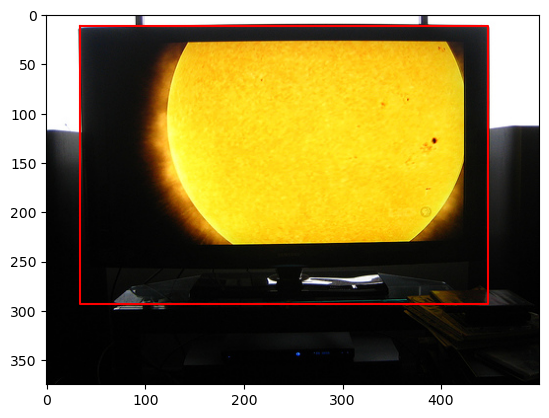

In [31]:
fig, ax = plt.subplots()
x, y = get_cor(anno[0]['object'])
ax.plot(x, y, color = 'red')
ax.imshow(img[0])
plt.show()

In [27]:
x, y

(['34', '448', '448', '34', '34'], ['11', '11', '293', '293', '11'])

In [32]:
import os
os.path.Pat('./ckpt_dir')

TypeError: 'module' object is not callable